In [1]:
from utils import compute_accuracy_metric, DataCollatorForSequences, MultiInputTextDs
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from models import WordSentRegressorWithStats
from tokens import WANDB_TOKEN
import pandas as pd
import os
import spacy
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from model_utils import TrainerForEssayScoring
import wandb
from torch.utils.data import DataLoader
from transformers import DebertaTokenizerFast
from tqdm import tqdm
tqdm.pandas()
torch.manual_seed(8)

/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# Defining folders
data_folder = "./learning-agency-lab-automated-essay-scoring-2/"
model_out = './word_sent_regressor'
log_out = './word_sent_regressor_logs'
if not os.path.exists(model_out):
    os.makedirs(model_out)
if not os.path.exists(log_out):
    os.makedirs(log_out)
os.listdir(data_folder)

['sample_submission.csv:Zone.Identifier',
 'sample_submission.csv',
 'test.csv:Zone.Identifier',
 'train.csv',
 'test.csv',
 'train.csv:Zone.Identifier']

In [3]:
# Loading data
essays_data = pd.read_csv(os.path.join(data_folder,'train.csv'))

Checking the distribution of essay lengths

In [4]:
essays_data['full_text'].str.len().describe()

count    17307.000000
mean      2071.617265
std        925.910701
min        712.000000
25%       1397.000000
50%       1924.000000
75%       2541.000000
max      20459.000000
Name: full_text, dtype: float64

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(essays_data['full_text'], essays_data['score'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

- Approach
    - We want to build both sentence level features & word level features. 
    - For word level features, we can use a distill bert token embeddings & for sentences level attributes we can utilize a sentence transformer model

In [6]:
# Loading Word embedding model & tokenizer - We will use 
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Loading sentence embedding model
sentence_bert = SentenceTransformer("thenlper/gte-small")

/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [8]:
spacy_model = spacy.load('en_core_web_lg')

In [10]:
# Creating train, test & val datasets
train_ds = MultiInputTextDs(X_train.values.tolist(), y_train.values.tolist(), tokenizer, model ,sentence_bert, spacy_model,True)
val_ds = MultiInputTextDs(X_val.values.tolist(), y_val.values.tolist(), tokenizer, model ,sentence_bert, spacy_model,True)
test_ds = MultiInputTextDs(X_test.values.tolist(), y_test.values.tolist(), tokenizer, model ,sentence_bert, spacy_model,True)

Extracting Sentences


100%|██████████| 2596/2596 [00:31<00:00, 82.15it/s] 


Extracting number_of_sentences


100%|██████████| 2596/2596 [00:00<00:00, 47443.45it/s]


Extracting number_of_unique_pos_tags


100%|██████████| 2596/2596 [00:00<00:00, 14673.46it/s]


Extracting number_of_unique_dep_tags


100%|██████████| 2596/2596 [00:00<00:00, 14435.62it/s]


Extracting number_of_unique_ents


100%|██████████| 2596/2596 [00:00<00:00, 64748.78it/s]


Extracting average_words_per_sentence


100%|██████████| 2596/2596 [00:00<00:00, 73642.51it/s]


Extracting percent_passive_sentences


100%|██████████| 2596/2596 [00:00<00:00, 9098.05it/s]


Extracting percent_simple_sentences


100%|██████████| 2596/2596 [00:01<00:00, 2566.96it/s]


Extracting percent_compound_sentences


100%|██████████| 2596/2596 [00:01<00:00, 1339.50it/s]


Extracting percent_complex_sentences


100%|██████████| 2596/2596 [00:01<00:00, 2437.80it/s]


In [25]:
# Uncomment if you want to store the datasets. Considering it is taking only 5-10 mins to create the datasets, I am not storing them.
# import pickle

# # Assuming train_dataset, test_dataset, and val_dataset are your dataset objects
# datasets = {
#     'train': train_ds,
#     'test': test_ds,
#     'val': val_ds
# }

# # Save each dataset to a separate .pkl file
# for name, dataset in datasets.items():
#     with open(f'{name}_dataset.pkl', 'wb') as f:
#         pickle.dump(dataset, f)

In [26]:
# To load the datasets back
# import pickle

# # Assuming train_dataset, test_dataset, and val_dataset are your dataset objects
# datasets = {
#     'train': train_ds,
#     'test': test_ds,
#     'val': val_ds
# }

# # Save each dataset to a separate .pkl file
# for name, dataset in datasets.items():
#     with open(f'{name}_dataset.pkl', 'wb') as f:
#         pickle.dump(dataset, f)

In [8]:
# import pickle

# # Load each dataset from the .pkl file
# loaded_datasets = {}
# for name in ['train', 'test', 'val']:
#     with open(f'{name}_dataset.pkl', 'rb') as f:
#         loaded_datasets[name] = pickle.load(f)

# # Access the loaded datasets
# train_ds = loaded_datasets['train']
# test_ds = loaded_datasets['test']
# val_ds = loaded_datasets['val']

/home/giridhar/github/essay_scoring/.conda/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [12]:
# Creating instance of the model which works with word embeddings, sentence embeddings and stats features
regressor_model = WordSentRegressorWithStats(word_embed_dim=768, sent_embed_dim=384,num_stats_features=9)

In [13]:
print(regressor_model)

WordSentRegressorWithStats(
  (word_lstm_1): LSTM(768, 128, batch_first=True)
  (word_lstm_2): LSTM(128, 64, batch_first=True)
  (sent_lstm_1): LSTM(384, 128, batch_first=True)
  (sent_lstm_2): LSTM(128, 64, batch_first=True)
  (stats_seq): Sequential(
    (0): Linear(in_features=9, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=2, bias=True)
    (3): ReLU()
  )
  (fc1): Linear(in_features=130, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [14]:
# Loading trained weights - I used jarvislabs.ai to train the model
regressor_model.load_state_dict(torch.load('./stats_plus_combined.pth'))

/tmp/ipykernel_84675/3860305678.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  regressor_model.load_state_dict(torch.load('./stats_plus_combined.pth'))


<All keys matched successfully>

In [15]:
# Creating dataloader with the custom data collator
data_collator = DataCollatorForSequences(add_stats_feat=True)
train_dataloader = DataLoader(train_ds, batch_size=16, collate_fn=data_collator, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=16, collate_fn=data_collator, shuffle=False)

In [14]:
# Taking a sample batch from the dataloader
for batch in train_dataloader:
    b = batch
    break
b

In [17]:
# Defining our customer trainer
trainer = TrainerForEssayScoring(regressor_model, train_dataloader, val_dataloader, has_stats_features=True)

In [27]:
# I have trained for 14 epochs and saved the model
trainer.train(20)

### Testing the model on the test data

In [22]:
from model_utils import Evaluator

# Evaluating the model using Quadratic Weighted Kappa

test_dataloader = DataLoader(test_ds, batch_size=16, collate_fn=data_collator, shuffle=False)
qwk = Evaluator(regressor_model, test_dataloader).evaluate()

100%|██████████| 163/163 [01:16<00:00,  2.14it/s]

Quadratic weighted kappa is : 0.8003


**Looking for failure reasons**

In [ ]:
# Check the performance of the model on the test set
test_predictions = list()
test_labels = list()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        word_embedded, sent_embedded, stats_features, targets = batch['word_embeddings'].to("cuda"), batch['sentence_embeddings'].to("cuda"), batch['stats_features'].to("cuda"), batch['labels'].to("cuda")
        outputs = regressor_model(word_embedded, sent_embedded, stats_features)
        test_predictions.extend(outputs.detach().cpu().numpy())
        test_labels.extend(targets.detach().cpu().numpy())


100%|██████████| 163/163 [01:18<00:00,  2.07it/s]


(array([  2.,   1.,   3.,   6.,   9.,  25.,  72., 110., 152., 198., 319.,
        336., 337., 320., 244., 166., 118.,  77.,  46.,  33.,   6.,   8.,
          4.,   1.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([-2.22832322, -2.04994273, -1.87156224, -1.69318163, -1.51480114,
        -1.33642066, -1.15804017, -0.97965962, -0.80127913, -0.62289858,
        -0.44451809, -0.26613757, -0.08775707,  0.09062345,  0.26900396,
         0.44738448,  0.62576497,  0.80414551,  0.982526  ,  1.16090655,
         1.33928704,  1.51766753,  1.69604802,  1.87442863,  2.052809  ,
         2.23118973,  2.40957022,  2.58795071,  2.7663312 ,  2.94471169,
         3.12309217]),
 <BarContainer object of 30 artists>)

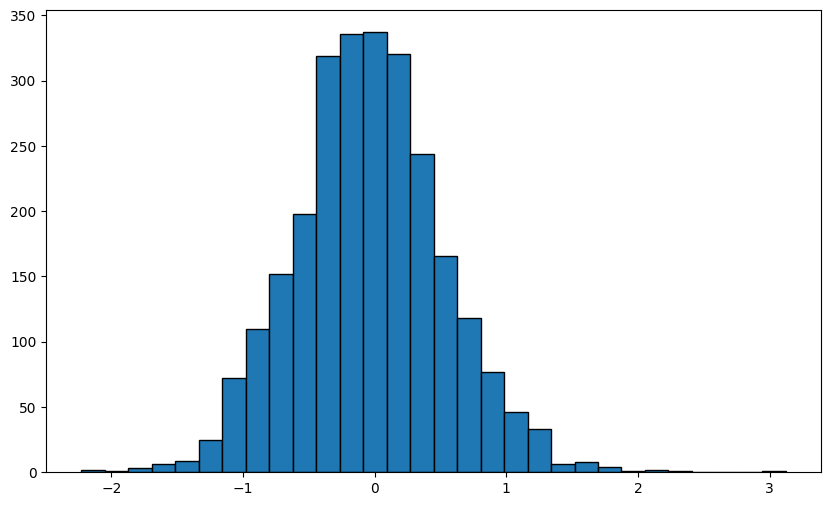

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns


test_predictions_df = pd.DataFrame({'predictions':test_predictions, 'labels':test_labels})
test_predictions_df['diff'] = test_predictions_df['predictions'] - test_predictions_df['labels']
test_predictions_df.sort_values(by='diff', ascending=False)
# Plotting the distribution of the differences
plt.figure(figsize=(10, 6))
plt.hist(test_predictions_df['diff'], bins=30, edgecolor='black')
plt.show()

**Checking to see if the model able to understand the train set well, to ensure no overfitting or underfitting is happening.**

In [18]:
# Evaluate on the train dataset use Evaluator inference loop here for modification
regressor_model.eval()
train_predictions = list()
labels = list()
regressor_model.to("cuda")

with torch.no_grad():
    for batch in tqdm(train_dataloader):
        word_embedded, sent_embedded, stats_features, targets = batch['word_embeddings'].to("cuda"), batch['sentence_embeddings'].to("cuda"), batch['stats_features'].to("cuda"), batch['labels'].to("cuda")
        outputs = regressor_model(word_embedded, sent_embedded, stats_features)
        # Rounding predictions to the nearest integer
        outputs = torch.round(outputs)
        train_predictions.extend(outputs.cpu().numpy())
        labels.extend(targets.cpu().numpy())

100%|██████████| 758/758 [06:24<00:00,  1.97it/s]


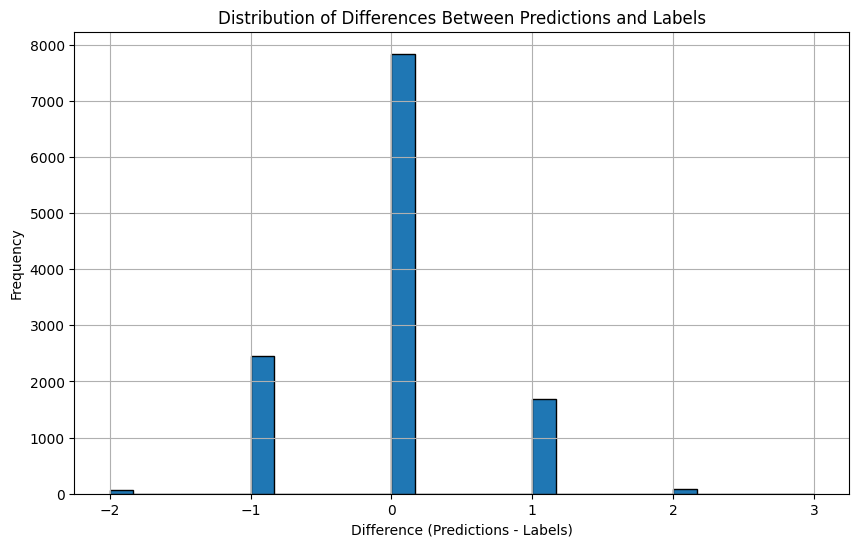

In [19]:
# Identify where the model is making mistakes very far away from the actual label
train_predictions_df = pd.DataFrame({'predictions':train_predictions, 'labels':labels})
train_predictions_df['diff'] = train_predictions_df['predictions'] - train_predictions_df['labels']
train_predictions_df.sort_values(by='diff', ascending=False)
# Plotting the distribution of the differences
import matplotlib.pyplot as plt

# Plotting the distribution of the differences
plt.figure(figsize=(10, 6))
plt.hist(train_predictions_df['diff'], bins=30, edgecolor='black')
plt.title('Distribution of Differences Between Predictions and Labels')
plt.xlabel('Difference (Predictions - Labels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Plotting the distribution of the differences

<Axes: title={'center': 'Mean Difference Between Predictions and Labels by Label'}, xlabel='Labels', ylabel='Mean Difference'>

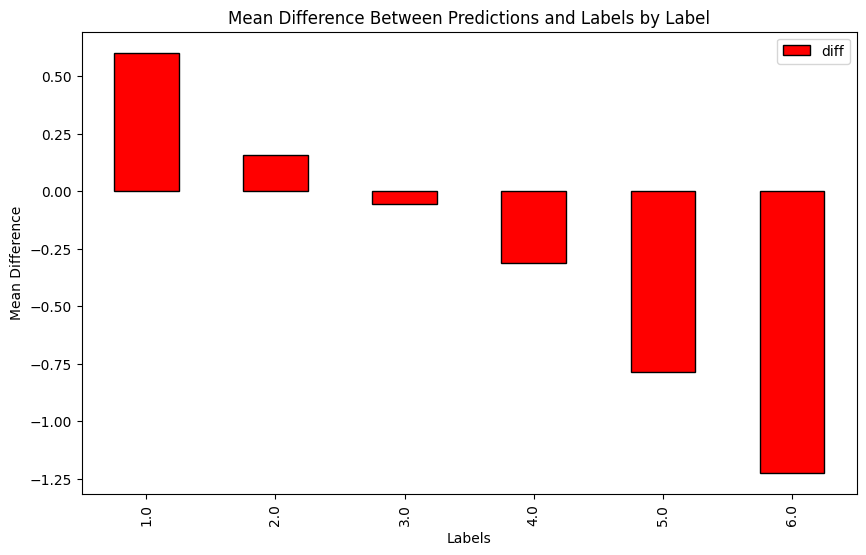

In [30]:
# Error rate across the labels and plot it
train_predictions_df.groupby('labels').agg({'diff':'mean'}).reset_index().sort_values(by='labels').plot(kind='bar', x='labels', y='diff', color='red', edgecolor='black', figsize=(10, 6), title='Mean Difference Between Predictions and Labels by Label', xlabel='Labels', ylabel='Mean Difference')
# Sample where the model is making mistakes very far away from the actual label

<Figure size 1000x600 with 0 Axes>

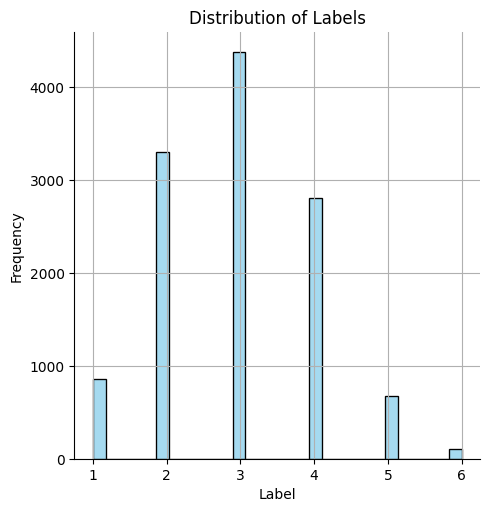

In [42]:
# Looks like label 6.0 has more errors is it because of data imbalance?
# Plotting the distribution of the labels
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.displot(train_predictions_df['labels'].apply(lambda x: int(x)), color='skyblue')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

,predictions,labels,diff
2056,4.123092,1.0,3.123092
2178,3.367877,1.0,2.367877
260,3.184780,1.0,2.184780
1220,5.136818,3.0,2.136818
1158,2.977517,1.0,1.977517
...,...,...,...
945,4.282349,6.0,-1.717651
693,2.253955,4.0,-1.746045
282,4.115968,6.0,-1.884032
84,1.845694,4.0,-2.154306


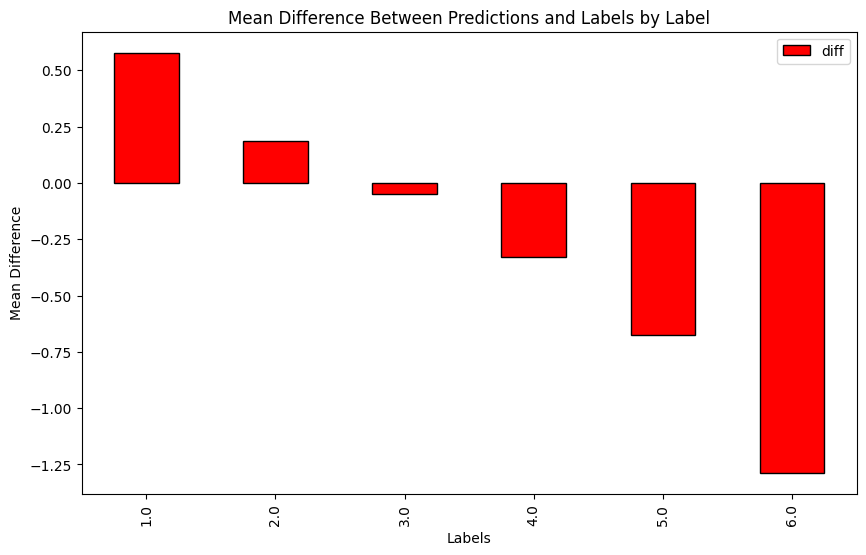

In [48]:
# Error rate across the labels and plot it
test_predictions_df.groupby('labels').agg({'diff':'mean'}).reset_index().sort_values(by='labels').plot(kind='bar', x='labels', y='diff', color='red', edgecolor='black', figsize=(10, 6), title='Mean Difference Between Predictions and Labels by Label', xlabel='Labels', ylabel='Mean Difference')
# Sample where the model is making mistakes very far away from the actual label
test_predictions_df.sort_values(by='diff', ascending=False)

Same is the case with the test set as well

In [17]:
# Lets verify the same on Validation set also
val_predictions = list()
val_labels = list()
regressor_model.to("cuda")
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        word_embedded, sent_embedded, stats_features, targets = batch['word_embeddings'].to("cuda"), batch['sentence_embeddings'].to("cuda"), batch['stats_features'].to("cuda"), batch['labels'].to("cuda")
        outputs = regressor_model(word_embedded, sent_embedded, stats_features)
        # Rounding predictions to the nearest integer
        outputs = torch.round(outputs)
        val_predictions.extend(outputs.cpu().numpy())
        val_labels.extend(targets.cpu().numpy())

100%|██████████| 163/163 [01:16<00:00,  2.13it/s]


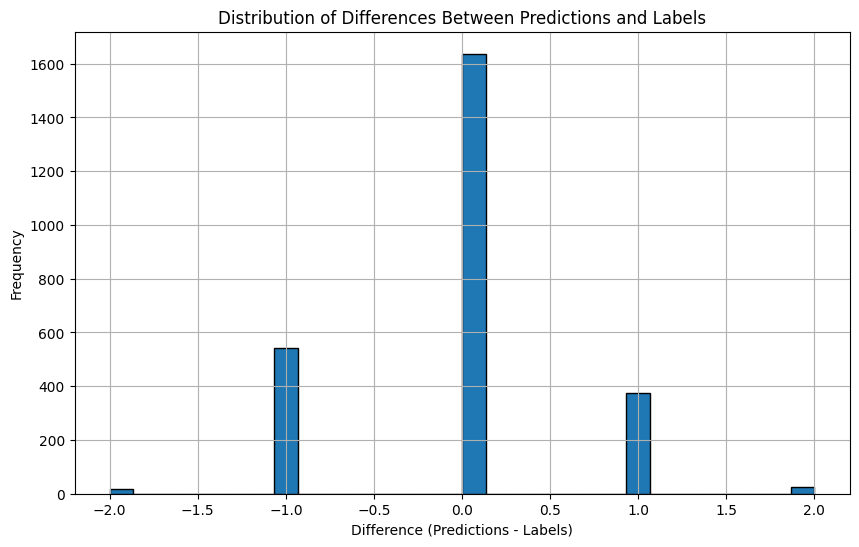

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# Identify where the model is making mistakes very far away from the actual label
val_predictions_df = pd.DataFrame({'predictions':val_predictions, 'labels':val_labels})
val_predictions_df['diff'] = val_predictions_df['predictions'] - val_predictions_df['labels']
val_predictions_df.sort_values(by='diff', ascending=False)
# Plotting the distribution of the differences
plt.figure(figsize=(10, 6))
plt.hist(val_predictions_df['diff'], bins=30, edgecolor='black')
plt.title('Distribution of Differences Between Predictions and Labels')
plt.xlabel('Difference (Predictions - Labels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


<Axes: title={'center': 'Mean Difference Between Predictions and Labels by Label'}, xlabel='Labels', ylabel='Mean Difference'>

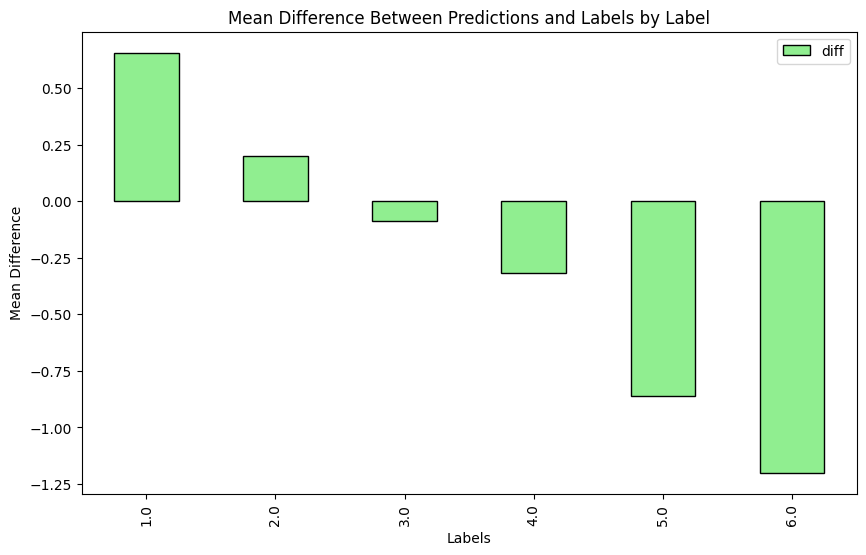

In [22]:
# Error rate across the labels and plot it
val_predictions_df.groupby('labels').agg({'diff':'mean'}).reset_index().sort_values(by='labels').plot(kind='bar', x='labels', y='diff', color='lightgreen', edgecolor='black', figsize=(10, 6), title='Mean Difference Between Predictions and Labels by Label', xlabel='Labels', ylabel='Mean Difference')

Similar observations as the test set

In [24]:
# TLDR:  We need more data for the model to generalize better. It is making mistakes in the low frequency labels.